# PNN for particle detection in HEP

In [56]:
import numpy as np
import matplotlib.pyplot as plt

Classification of signal events to background events with different particle masses.

## 0) Signal and background events
Gauss distributions of which one is the background and the others are signals at different masses.

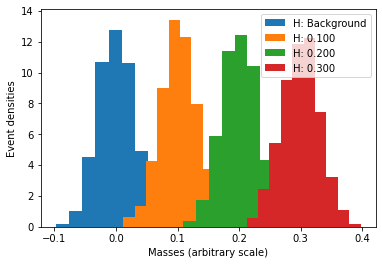

In [57]:
np.random.seed(42)
sizes = 1000
peaks = np.array([0.00, 0.10, 0.20, 0.30 ])
labels = ["Background", "0.100", "0.200", "0.300"]
data = [np.random.normal(loc=peak, scale=0.03, size=sizes) for peak in peaks]
for idx, d in enumerate(data):
    plt.hist(d, bins=10, label=f"H: {labels[idx]}", density=True)
plt.legend()
plt.xlabel("Masses (arbitrary scale)")
plt.ylabel("Event densities")
plt.show()

## 1) Create custom dataset for training the PNN

In [58]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

In [59]:
class CustomDataset(Dataset):
    def __init__(self, masses = np.linspace(0, 1.0, 20),
                       data_points: int = 100,
                       total_generations: int = 10000):
        np.random.seed(42)
        self.masses = masses
        self.data_points = data_points
        self.total_generations = total_generations
        self.dataset = {}
        for gen_num in range(self.total_generations):
            # coordinate generation
            X = np.zeros(shape=(self.data_points * 2, 3))
            Y = np.concatenate([np.zeros(self.data_points), np.ones(self.data_points)])
            # randomly generated gaussian curves for background and different masses
            random_mass = np.random.choice(self.masses[1:])
            X[:self.data_points, 0] = np.random.normal(loc = self.masses[0], scale = 0.02, size = self.data_points)
            X[self.data_points:, 0] = np.random.normal(loc = random_mass, scale = 0.02, size = self.data_points)
            X[:, 1] = np.ones(self.data_points * 2) * self.masses[0]
            X[:, 2] = np.ones(self.data_points * 2) * random_mass


            # make tensors
            X = torch.tensor(X, requires_grad=True).float()
            Y = torch.tensor(Y, requires_grad=True).float()

            self.dataset[gen_num] = (X, Y)

    def __len__(self):
        return self.total_generations # len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1]

Generate the data.

In [60]:
custom_ds = CustomDataset()
custom_dl = DataLoader(custom_ds, batch_size=10, shuffle=True)

Example of dataset event.

In [61]:
custom_ds[0]

(tensor([[-0.0110,  0.0000,  0.3684],
         [ 0.0103,  0.0000,  0.3684],
         [ 0.0095,  0.0000,  0.3684],
         [ 0.0274,  0.0000,  0.3684],
         [-0.0183,  0.0000,  0.3684],
         [-0.0025,  0.0000,  0.3684],
         [-0.0402,  0.0000,  0.3684],
         [-0.0099,  0.0000,  0.3684],
         [ 0.0079,  0.0000,  0.3684],
         [-0.0186,  0.0000,  0.3684],
         [ 0.0016,  0.0000,  0.3684],
         [-0.0032,  0.0000,  0.3684],
         [ 0.0004,  0.0000,  0.3684],
         [-0.0086,  0.0000,  0.3684],
         [-0.0106,  0.0000,  0.3684],
         [-0.0023,  0.0000,  0.3684],
         [ 0.0044,  0.0000,  0.3684],
         [-0.0154,  0.0000,  0.3684],
         [ 0.0028,  0.0000,  0.3684],
         [-0.0007,  0.0000,  0.3684],
         [ 0.0227,  0.0000,  0.3684],
         [-0.0021,  0.0000,  0.3684],
         [-0.0105,  0.0000,  0.3684],
         [ 0.0383,  0.0000,  0.3684],
         [-0.0405,  0.0000,  0.3684],
         [ 0.0224,  0.0000,  0.3684],
         [ 0

## 2) Construct NN Network with extra input feature 

In [62]:
import torch.nn as nn
import torch.nn.functional as F

In [63]:
class ParameterizedNeuralNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.net = nn.Sequential(nn.Linear(in_features=3, out_features=20),
                                 nn.ReLU(),
                                 nn.Linear(in_features=20, out_features=20),
                                 nn.ReLU(),
                                 nn.Linear(in_features=20, out_features=20),
                                 nn.ReLU(),
                                 nn.Linear(in_features=20, out_features=20),
                                 nn.ReLU(),
                                 nn.Linear(in_features=20, out_features=1),
                                 nn.Sigmoid())
    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optim  = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optim

    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch
        Y_hat = self.net(X)
        loss = F.binary_cross_entropy(torch.squeeze(Y_hat, -1), Y)
        self.losses.append(loss.detach().numpy())
        self.log("train_loss", loss)
        return loss

## 3) Train the NN

In [64]:
model = ParameterizedNeuralNet()
trainer = pl.Trainer(max_epochs=25, progress_bar_refresh_rate=10)
trainer.fit(model, custom_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## 4) Loss of the training

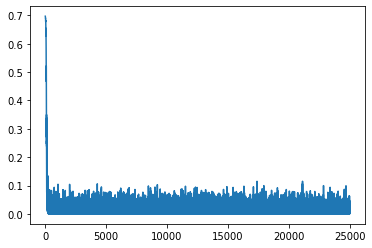

In [65]:
losses = np.asarray(model.losses)
losses.shape

plt.plot(np.arange(0,losses.shape[0]), losses)

## 5) Test some examples of PNN

Visualization of different mass hypotheses plotted against different masses.

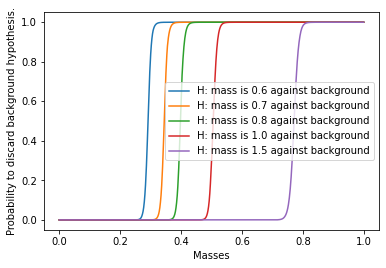

In [67]:
masses = np.linspace(0.00, 1.00, 1000)
bg = 0.0

for mass in [0.600, 0.700, 0.800, 1.00, 1.5]:
    hypothesis = np.ones_like(masses) * mass
    background = np.ones_like(masses) * bg

    data = np.empty((1000, 3))
    data[:, 0] = masses
    data[:, 1] = background
    data[:, 2] = hypothesis

    data_tensor = torch.tensor(data).float()

    res = model(data_tensor).detach().numpy()

    if mass == 0.750:
        plt.plot(masses, res, label=f"H: mass is {mass} against background. Not trained on!")
    else:    
        plt.plot(masses, res, label=f"H: mass is {mass} against background")
plt.xlabel("Masses")
plt.ylabel("Probability to discard background hypothesis.")
plt.legend()
plt.show()


## 6) ROC and AUC